In [14]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("justinpakzad/vestiaire-fashion-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, 'vestiaire.csv'), low_memory=False)

Path to dataset files: /Users/banutiryaki/.cache/kagglehub/datasets/justinpakzad/vestiaire-fashion-dataset/versions/2


In [15]:
df['item_type'] = df['product_type'].str.strip().str.split().str[-1].str.lower()

In [42]:
df['brand_name'].nunique()

8884

In [16]:
type_counts = df['item_type'].value_counts()
df = df[df['item_type'].isin(type_counts[type_counts > 1].index)]

In [17]:
brand_counts = df['brand_name'].value_counts()

top_n = [50, 100, 200, 500, 1000, 2000]
for n in top_n:
    covered = brand_counts.iloc[:n].sum()
    total = len(df)
    percent = round(covered / total * 100, 2)
    print(f"Top {n} brands cover {covered} products ({percent}%)")


Top 50 brands cover 413161 products (45.88%)
Top 100 brands cover 528278 products (58.66%)
Top 200 brands cover 629866 products (69.95%)
Top 500 brands cover 743651 products (82.58%)
Top 1000 brands cover 809934 products (89.94%)
Top 2000 brands cover 857565 products (95.23%)


In [18]:
top_1000_brands = df['brand_name'].value_counts().nlargest(1000).index
df['brand_trimmed'] = df['brand_name'].where(df['brand_name'].isin(top_1000_brands), 'other')

In [19]:
condition_map = {
    'Fair condition': 0,
    'Good condition': 1,
    'Very good condition': 2,
    'Never worn': 3,
    'Never worn, with tag': 4
}
df['product_condition_mapped'] = df['product_condition'].map(condition_map)


In [20]:
gender_map = {
    'Women': 0,
    'Men': 1
}
df['gender_encoded'] = df['product_gender_target'].map(gender_map)


In [21]:
df = df[df['price_usd'] != df['price_usd'].max()]

In [22]:
from sklearn.preprocessing import LabelEncoder

df_model = df.copy()
brand_encoder = LabelEncoder()
df_model['brand_encoded'] = brand_encoder.fit_transform(df_model['brand_trimmed'])

df_model = pd.get_dummies(df_model, columns=['item_type'], prefix='item')


feature_cols = (
    [col for col in df_model.columns if col.startswith('item_')] + 
    ['brand_encoded', 'product_condition_mapped', 'gender_encoded']
)

X = df_model[feature_cols]
y = df_model['price_usd']



In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,  
    max_depth=None,    
    random_state=42,
    n_jobs=-1          
)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")


R² Score: 0.3685
MAE: $209.72
RMSE: $1137.71


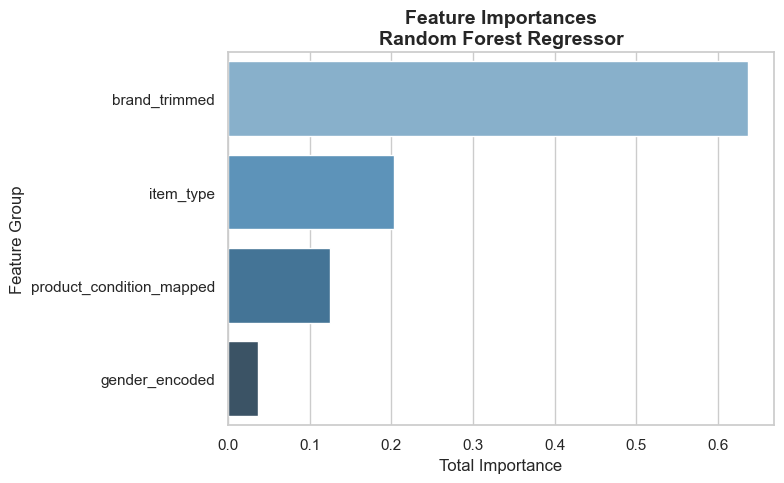

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Get raw importances
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Group item_type features under one label
def categorize_feature(name):
    if name.startswith("item_"):
        return "item_type"
    elif name == "brand_encoded":
        return "brand_trimmed"
    else:
        return name  

feat_imp_df['category'] = feat_imp_df['feature'].apply(categorize_feature)
grouped = feat_imp_df.groupby('category')['importance'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

# Horizontal bar plot
sns.barplot(
    x=grouped.values,
    y=grouped.index,
    palette="Blues_d"
)

# Titles and labels
plt.xlabel("Total Importance", fontsize=12)
plt.ylabel("Feature Group", fontsize=12)
plt.title("Feature Importances\nRandom Forest Regressor", fontsize=14, fontweight="bold")

# Clean layout
plt.tight_layout()
plt.show()


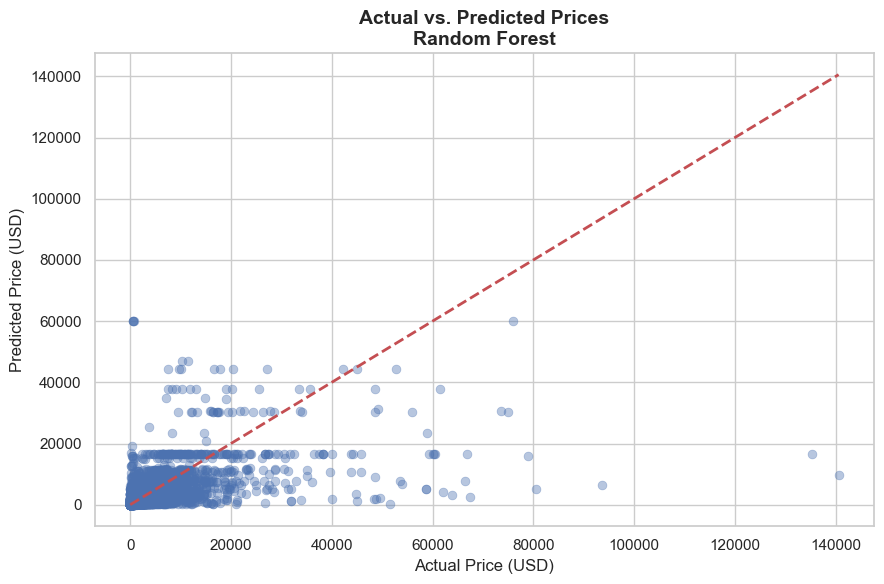

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
sns.set(style="whitegrid")

# Scatterplot
sns.scatterplot(
    x=y_test, 
    y=y_pred, 
    alpha=0.4, 
    edgecolor=None,
    s=40
)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel("Actual Price (USD)", fontsize=12)
plt.ylabel("Predicted Price (USD)", fontsize=12)
plt.title("Actual vs. Predicted Prices\nRandom Forest", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


/Users/banutiryaki/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


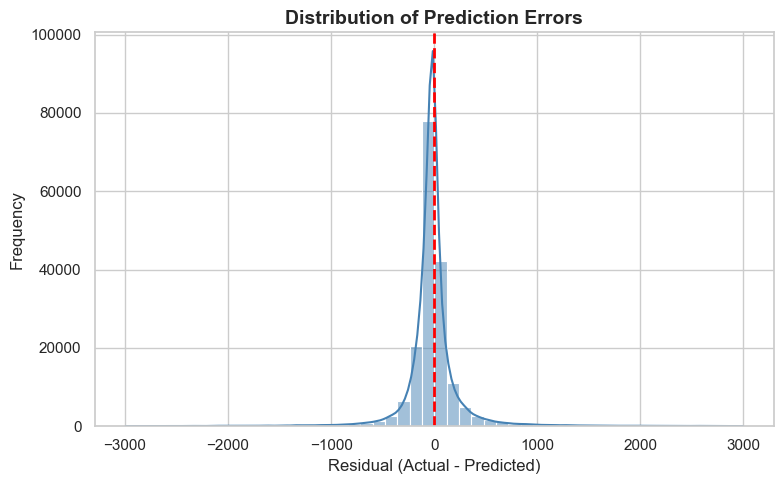

In [37]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

# Compute residuals
residuals = y_test - y_pred

residuals_clipped = residuals[residuals.between(-3000, 3000)]

# Plot
sns.histplot(residuals_clipped, bins=50, kde=True, color='steelblue')

plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Residual (Actual - Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Prediction Errors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
